# Model Quantization

## Importing Packages

In [2]:
# load necessary libraries
import os
import time
import torch
import optuna
import random
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna.trial import TrialState
from pathlib import Path

from typing import Optional, Union, Any, Dict

from datasets import Dataset
from datasets import load_dataset, DatasetDict

from transformers import (AutoTokenizer, TFAutoModel, pipeline, MarianMTModel, MarianTokenizer,
                         AutoModelForSequenceClassification, TrainingArguments, Trainer,
                         AutoModelForMaskedLM, EarlyStoppingCallback)

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.filterwarnings('ignore')

## Importing Model

In [7]:
cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, "..", "part_3", "final_model"))

model100 = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    use_safetensors=True
)
model100.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## a) Distill/Quantize your best-performing model into a lighter model

We will use Dynamic quantization where weights are quantized and stored in int8, and there is no need to retrain the model

To do this we will use the official PyTorch quantization toolkit: torch.quantization

In [8]:
quantized_model = torch.quantization.quantize_dynamic(
    model100, 
    {torch.nn.Linear},  # Only quantize Linear layers
    dtype=torch.qint8 #converting from 32-bit-float to 8-bit integer
)

We only quantize the linear layers of the model as these are the most compute-heavy layers in BERT-like models. Model quantization will specially benefit users running the model on a CPU

In [9]:
# Define relative path using pathlib
quantized_model_path = Path("quantized_model") / "pytorch_model.bin"

# Save the quantized model's state dict
torch.save(quantized_model.state_dict(), quantized_model_path)

## b) Performance and Speed Comparison 

Defining tokenizer and global random seeds

In [5]:
# set global seeds to all the processes
def set_global_seeds(seed=42):
    # Python
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # to have compatibiliy with GPU
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_global_seeds(42)
seed=42

model_ckpt   = "distilbert/distilbert-base-uncased"
num_labels   = 5
max_length   = 128                   # truncate / pad length
batch_size   = 16

# Define Tokenizer
tok = AutoTokenizer.from_pretrained(model_ckpt)
def tokenize(batch):
    tokenized = tok(
        batch["comment_text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    tokenized["labels"] = [
        [float(batch[label][i]) for label in labels]
        for i in range(len(batch["comment_text"]))
    ]
    return tokenized

Importing data to test the speed

In [33]:
from datasets import load_dataset
df = load_dataset("Arsive/toxicity_classification_jigsaw")
val = df["validation"].to_pandas()
val = val.drop(columns=["threat"])
# Preserve original metadata (comment_text and id) we will use it for later comparison
val_metadata = val[["comment_text"]].copy()
val_metadata.reset_index(drop=True, inplace=True)

train = df["train"].to_pandas()
train = train.drop(columns=["threat"])

In [31]:
labels= ["toxic", "severe_toxic", "obscene", "insult", "identity_hate"]
from torch.utils.data import DataLoader
val = Dataset.from_pandas(val).remove_columns("id")
val = val.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
val.set_format("torch", ["input_ids","attention_mask","labels"])
val_loader = DataLoader(val, batch_size=batch_size)

Map: 100%|██████████| 6490/6490 [00:00<00:00, 11760.71 examples/s]


testing models speed

In [8]:
# Main model
model100.to("cpu").eval()

# Quantized model
quantized_model.to("cpu").eval()

# -----------------------------
# Benchmark Function
# -----------------------------
def benchmark_model(model, dataloader, num_batches=20):
    total_time = 0.0
    n = 0
    with torch.no_grad():
        # Warm-up
        for i, batch in enumerate(dataloader):
            if i >= 3:
                break
            _ = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Timed run
        for i, batch in enumerate(dataloader):
            if i >= num_batches:
                break
            start = time.time()
            _ = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            end = time.time()
            total_time += (end - start)
            n += 1

    avg_time_ms = (total_time / n) * 1000
    return avg_time_ms

# -----------------------------
# Run Benchmarks
# -----------------------------
fp32_time = benchmark_model(model100, val_loader)
int8_time = benchmark_model(quantized_model, val_loader)

print(f"🔹 FP32 model:  {fp32_time:.2f} ms per batch")
print(f"🔹 INT8 model:  {int8_time:.2f} ms per batch")
print(f"⚡ Speedup:     {fp32_time / int8_time:.2f}x faster")


🔹 FP32 model:  452.98 ms per batch
🔹 INT8 model:  339.20 ms per batch
⚡ Speedup:     1.34x faster


Now for perfomance comparison:

In [9]:
def evaluate_multilabel_model(
    trainer,
    eval_dataset,
    label_names,
    threshold=0.5,
    plot_confusion=True,
    normalize_confusion=True
):
    """
    Performs detailed evaluation of a multi-label classification model trained with Hugging Face Trainer.

    Args:
        trainer (Trainer): Trained Hugging Face Trainer object.
        eval_dataset (Dataset): Tokenized evaluation dataset.
        label_names (List[str]): List of label column names (e.g., ["toxic", ...]).
        threshold (float): Threshold for converting sigmoid outputs to binary (default: 0.5).
        plot_confusion (bool): Whether to plot confusion matrices.
        normalize_confusion (bool): If True, display percentages instead of absolute counts.

    Prints:
        - Classification report with per-class precision/recall/F1
        - Confusion matrices (optionally normalized and visualized)
    """
    # 1. Predict and threshold
    predictions_output = trainer.predict(eval_dataset)
    logits = predictions_output.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs >= threshold).astype(int)
    y_true = predictions_output.label_ids

    # 2. Classification report
    print("\n Classification Report:")
    report = classification_report(
        y_true,
        y_pred,
        target_names=label_names,
        digits=4
    )
    print(report)

    # 3. Confusion Matrices
    print("\n Confusion Matrices:")
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

    for i, label in enumerate(label_names):
        cm = conf_matrices[i]

        # Normalize to percentage if requested
        if normalize_confusion:
            cm_sum = cm.sum()
            cm = cm.astype("float") / cm_sum * 100 if cm_sum > 0 else cm

        print(f"\nConfusion Matrix for '{label}':")
        print(np.round(cm, 2))

        if plot_confusion:
            plt.figure(figsize=(3, 3))
            sns.heatmap(
                cm,
                annot=True,
                fmt=".1f" if normalize_confusion else "d",
                cmap="Blues",
                cbar=False
            )
            plt.title(f"Confusion Matrix: {label}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()

In [10]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")
metric_f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Cast labels to integer type before passing to metrics
    labels_int = labels.astype(int)

    # Flatten the predictions and references for evaluation metrics
    preds_flat = preds.flatten()
    labels_int_flat = labels_int.flatten()

    # Use the flattened arrays for computing metrics
    # Note: Accuracy on flattened arrays represents overall element-wise accuracy.
    # For multi-label accuracy, you might want to compute sample-based metrics,
    # but for average="macro" precision/recall/f1, flattening is appropriate.
    acc  = metric_accuracy.compute(predictions=preds_flat, references=labels_int_flat)
    prec = metric_precision.compute(predictions=preds_flat, references=labels_int_flat, average="macro")
    rec  = metric_recall.compute(predictions=preds_flat, references=labels_int_flat, average="macro")
    f1   = metric_f1.compute(predictions=preds_flat, references=labels_int_flat, average="macro")

    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
        "f1":        f1["f1"],
    }

In [ ]:
# Arguments for full model
args_1_base = TrainingArguments(
    output_dir          = "./bert_1",
    eval_strategy       = "epoch",
    save_strategy       = "no",
    logging_strategy    = "steps",
    logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = False,
    metric_for_best_model = "eval_f1",
    save_total_limit    = 2,
    seed                = seed,
    use_cpu =True,
    report_to           = "none",  # Disable wandb
    fp16                = True # Enable mixed precision training
)

# Arguments for quantized model
args_int8 = TrainingArguments(
    output_dir="./int8_eval",
    per_device_eval_batch_size=batch_size,
    use_cpu =True,  # 🚨 dynamic quantized models only work on CPU
    report_to="none"
)

In [12]:
train_100 = Dataset.from_pandas(train).remove_columns("id")
train_100 = train_100.map(tokenize, batched=True, remove_columns=["comment_text"] + labels)
train_100.set_format("torch", ["input_ids","attention_mask","labels"])

Map: 100%|██████████| 25960/25960 [00:02<00:00, 10885.17 examples/s]


Loading the trainers objects (we will not train, but they are necessary for evaluating performance)

In [13]:
trainer_int8 = Trainer(
    model           = quantized_model,
    args            = args_int8,   
    eval_dataset    = val,
    compute_metrics = compute_metrics 
)
trainer_100 = Trainer(
    model           = model100,
    args            = args_1_base,
    eval_dataset    = val,
    compute_metrics = compute_metrics
)

Running performance evaluations

In [ ]:
# Per Label performance
print("\n📊 Evaluating FP32 (Original) Model:")
evaluate_multilabel_model(
    trainer=trainer_100,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=False
)

print("\n📊 Evaluating INT8 (Quantized) Model:")
evaluate_multilabel_model(
    trainer=trainer_int8,
    eval_dataset=val,
    label_names=labels,
    threshold=0.5,
    plot_confusion=False
)



📊 Evaluating FP32 (Original) Model:



 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9784    0.9842    0.9813      3034
 severe_toxic     0.8302    0.8406    0.8354       320
      obscene     0.9593    0.9704    0.9648      1653
       insult     0.9410    0.9416    0.9413      1559
identity_hate     0.9129    0.9198    0.9163       262

    micro avg     0.9558    0.9619    0.9588      6828
    macro avg     0.9244    0.9313    0.9278      6828
 weighted avg     0.9558    0.9619    0.9588      6828
  samples avg     0.4738    0.4758    0.4717      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[52.23  1.02]
 [ 0.74 46.01]]

Confusion Matrix for 'severe_toxic':
[[94.22  0.85]
 [ 0.79  4.14]]

Confusion Matrix for 'obscene':
[[73.48  1.05]
 [ 0.76 24.71]]

Confusion Matrix for 'insult':
[[74.56  1.42]
 [ 1.4  22.62]]

Confusion Matrix for 'identity_hate':
[[95.61  0.35]
 [ 0.32  3.71]]

📊 Evaluating INT8 (Quantized) Model:


c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor 


 Classification Report:
               precision    recall  f1-score   support

        toxic     0.9825    0.9268    0.9539      3034
 severe_toxic     0.9027    0.3187    0.4711       320
      obscene     0.9416    0.9564    0.9490      1653
       insult     0.9418    0.8922    0.9163      1559
identity_hate     0.9667    0.3321    0.4943       262

    micro avg     0.9601    0.8748    0.9155      6828
    macro avg     0.9471    0.6853    0.7569      6828
 weighted avg     0.9590    0.8748    0.9039      6828
  samples avg     0.4486    0.4303    0.4342      6828


 Confusion Matrices:

Confusion Matrix for 'toxic':
[[52.48  0.77]
 [ 3.42 43.33]]

Confusion Matrix for 'severe_toxic':
[[94.9   0.17]
 [ 3.36  1.57]]

Confusion Matrix for 'obscene':
[[73.02  1.51]
 [ 1.11 24.36]]

Confusion Matrix for 'insult':
[[74.65  1.33]
 [ 2.59 21.43]]

Confusion Matrix for 'identity_hate':
[[9.592e+01 5.000e-02]
 [2.700e+00 1.340e+00]]


c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aleja\OneDrive\Escritorio\Term_3\nlp-toxicity-classification-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor 

Aggregated Performance

In [15]:
eval_results_100 = trainer_100.evaluate(eval_dataset=val)

print("\n📊 Evaluation Results (FP32 - Full Model):")
print(f"  Accuracy:  {eval_results_100['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_100['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_100['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_100['eval_f1']:.4f}")



📊 Evaluation Results (FP32 - Full Model):
  Accuracy:  0.9826
  Precision: 0.9728
  Recall:    0.9750
  F1 Score:  0.9739


In [16]:
eval_results_int8 = trainer_int8.evaluate(eval_dataset=val)

print("\n📊 Evaluation Results (INT8 - Quantized Model):")
print(f"  Accuracy:  {eval_results_int8['eval_accuracy']:.4f}")
print(f"  Precision: {eval_results_int8['eval_precision']:.4f}")
print(f"  Recall:    {eval_results_int8['eval_recall']:.4f}")
print(f"  F1 Score:  {eval_results_int8['eval_f1']:.4f}")



📊 Evaluation Results (INT8 - Quantized Model):
  Accuracy:  0.9660
  Precision: 0.9638
  Recall:    0.9326
  F1 Score:  0.9471


## C)  Analysis and Improvements 

Overall, the performance loss from quantization is minimal, while achieving a 30–40% speedup in inference time on CPU. However, it's worth noting that recall dropped significantly for the severe_toxic and identity_hate labels, even though precision remained relatively strong. This likely stems from the fact that these classes are underrepresented in the dataset, comprising only 5.00% and 4.33% of the samples, respectively. As a result, the simplification introduced by quantization may have led to the model losing some of the finer-grained patterns needed to correctly identify these rare cases.

We will analyze some examples for these two classes. Specifically, when the full model made an accurate prediction but the Quantized model did not:

In [26]:
# Set rare labels to inspect
rare_labels = ["severe_toxic", "identity_hate"]
rare_indices = [labels.index(lbl) for lbl in rare_labels]

# Convert val to a list of dictionaries
val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_list = [val[i] for i in range(len(val))]

results = []

# Run inference on both models
model100.eval().to("cpu")
quantized_model.eval().to("cpu")

with torch.no_grad():
    for i, sample in tqdm(enumerate(val_list), total=len(val_list)):
        input_ids = sample["input_ids"].unsqueeze(0)
        attention_mask = sample["attention_mask"].unsqueeze(0)
        true_labels = sample["labels"].numpy()

        # Get predictions
        logits_fp32 = model100(input_ids=input_ids, attention_mask=attention_mask).logits
        logits_int8 = quantized_model(input_ids=input_ids, attention_mask=attention_mask).logits

        probs_fp32 = torch.sigmoid(logits_fp32).squeeze().numpy()
        probs_int8 = torch.sigmoid(logits_int8).squeeze().numpy()

        preds_fp32 = (probs_fp32 >= 0.5).astype(int)
        preds_int8 = (probs_int8 >= 0.5).astype(int)

        # Check for rare label hits
        for idx in rare_indices:
            if true_labels[idx] == 1 and preds_fp32[idx] == 1 and preds_int8[idx] == 0:
                results.append({
                    "id": i,  # 🔥 Now includes row index
                    "label": labels[idx],
                    "true": int(true_labels[idx]),
                    "fp32_pred": int(preds_fp32[idx]),
                    "int8_pred": int(preds_int8[idx]),
                    "fp32_prob": float(probs_fp32[idx]),
                    "int8_prob": float(probs_int8[idx])
                })


100%|██████████| 6490/6490 [16:04<00:00,  6.73it/s]


In [36]:
df_diff = pd.DataFrame(results)
# Step 3: Merge comment_text into df_diff using 'id'
val_metadata.index.name = "id"
# Merge using df_diff["id"] and val_metadata index
df_diff = df_diff.merge(val_metadata, on="id", how="left")

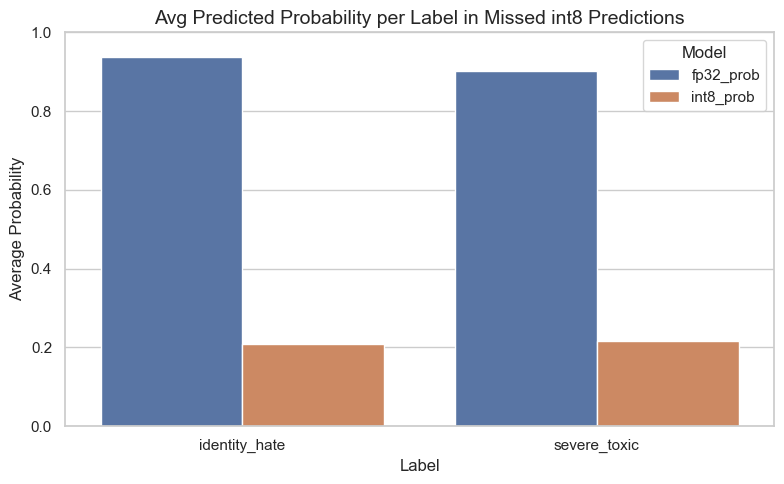

In [ ]:
# Group by label and compute average probability per model
avg_probs = df_diff.groupby("label")[["fp32_prob", "int8_prob"]].mean().reset_index()

# Melt for plotting
avg_probs_melted = avg_probs.melt(
    id_vars="label",
    value_vars=["fp32_prob", "int8_prob"],
    var_name="model",
    value_name="avg_probability"
)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_probs_melted,
    x="label",
    y="avg_probability",
    hue="model"
)

plt.title("Avg Predicted Probability per Label in Missed int8 Predictions", fontsize=14)
plt.ylabel("Average Probability", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


## Severe toxic analysis

In [47]:
# Filter only for 'severe_toxic' samples
severe_df = df_diff[df_diff["label"] == "severe_toxic"].copy()

# Compute absolute difference in predicted probabilities
severe_df["prob_diff"] = (severe_df["fp32_prob"] - severe_df["int8_prob"]).abs()

# Sort by difference and take top 2
top_diff = severe_df.sort_values(by="prob_diff", ascending=False).head(5)

# Display relevant info
cols_to_show = ["comment_text", "fp32_prob", "int8_prob", "prob_diff"]
print(top_diff[cols_to_show].to_string(index=False))


                                                                                                                                                                                                                                                                      comment_text  fp32_prob  int8_prob  prob_diff
                                                                                                                                                                        Dumb Liberals \n\nLiberals suck.  I will beat you at tanks anytime you swastika wearing freak.  Sieg Heil.   0.985693   0.007503   0.978190
                                                        Thanks for being late to the party \n\nbut I have added no new articles since yesterday.  While you have all been very impolite and overly protective, I have lost interest in torturing you, so you can go fuck yourself.   0.977846   0.015514   0.962333
                                                                            

The quantized model struggles to accurately identify uncommon or highly toxic language. This is likely because quantization reduces the model’s ability to preserve subtle distinctions that enable the full-precision model to classify these cases correctly. For example comments like:

"Dumb Liberals ... swastika wearing freak. Sieg Heil."

"i DONT KNOW HOW THIS THING WORKS... I OWN THIS FING CITY..."

contain less common or very informal/slang expressions.

Quantized models often generalize less well on out-of-distribution or unusual inputs due to precision loss.

## Identity hate analysis

In [48]:
# Filter only for 'identity_hate' samples
severe_df = df_diff[df_diff["label"] == "identity_hate"].copy()

# Compute absolute difference in predicted probabilities
severe_df["prob_diff"] = (severe_df["fp32_prob"] - severe_df["int8_prob"]).abs()

# Sort by difference and take top 2
top_diff = severe_df.sort_values(by="prob_diff", ascending=False).head(5)

# Display relevant info
cols_to_show = ["comment_text", "fp32_prob", "int8_prob", "prob_diff"]
print(top_diff[cols_to_show].to_string(index=False))

For identity hate a similar thing is happening, these comments are highly charged with specific language against ethnic or religious groups (e.g., "Kurd, "Turkish nationalist," "christian piece of shit"). The full model picks up these signals confidently, while quantization likely blunts or loses sensitivity to the key hateful keywords or phrases.

## Suggested improvements

1. Quantization-Aware Training (QAT):
Instead of applying quantization after training, QAT incorporates quantization effects directly during training. This helps the model learn representations that are robust to reduced precision, allowing it to maintain better accuracy—especially on subtle or rare toxic cases that suffer most from post-training quantization.

2. Advanced Distillation Methods:
In this work, we did not apply knowledge distillation; however, it represents a promising avenue for improvement. Distillation can be enhanced by transferring not only the final outputs but also intermediate representations such as hidden layer activations or attention maps. Using a larger, full-precision teacher model to guide a student model can help the student capture nuanced patterns learned by the teacher. This deeper mimicry might lead to improved classification performance, especially on complex or subtle examples.

3. Hybrid Quantization Strategies:
In our approach, we applied quantization selectively—only on the linear layers of the model—while leaving other components in full precision. Although this targeted quantization provides computational speedup, it still led to some degradation in performance. As an alternative, exploring mixed-precision quantization, where critical layers such as embeddings or attention modules are kept in higher precision (e.g., FP16 or FP32) while less sensitive layers are quantized, could better preserve accuracy. 